In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, Image, HTML
from ipywidgets import AppLayout, Button, Layout, GridspecLayout, IntProgress, Output, VBox, HBox
from numba.typed import List
from numba import njit, prange
from collections import deque
from os import path
import json
import pickle
pd.set_option('display.max_columns', None)

In [95]:
ALL_MODELS_CSV = './output.csv'
TURKERS_SCORES_JSON = '../mturk/analyzed_results/scores.json'

In [96]:
frame = pd.read_csv(ALL_MODELS_CSV, index_col=0)
frame['name'] = frame['name'].str.lower().astype('str')
frame['class'] = frame['class'].str.lower().astype('str')
frame[['price']] = frame['price'].fillna(value=0)
if 'status' not in frame.columns:
    frame['status'] = np.full(len(frame), -1)

In [97]:
with open('./classes.txt') as cl_file:
    classes = [x.strip().lower() for x in cl_file.readlines()]

In [98]:
def to_numba_list(strings):
    result = List()
    for x in strings:
        result.append(x)
    return result
        
        
@njit(parallel=True)
def disable_bad_items_numba(classes, names, statuses):
    for i in prange(len(classes)):
        name = names[i]
        clazz = classes[i]
        ok = False
        for word in clazz:
            if word in name:
                ok=True
                break
        if not ok:
            statuses[i] = 0
            
def disable_bad_items(frame):
    disable_bad_items_numba(to_numba_list(frame['class']), to_numba_list(frame['name']), frame['status'].to_numpy())

def sort_frame(frame):
    frame.sort_values(by='viewCount', kind='mergesort', ascending=False, inplace=True)
    frame.sort_values(by='price', kind='mergesort', inplace=True)
    frame.sort_values(by='class', kind='mergesort', inplace=True)

In [99]:
disable_bad_items(frame)
sort_frame(frame)
frame['free'] = (frame['price'].isna() | frame['price'] == 0)
with open(TURKERS_SCORES_JSON, 'r') as handle:
    score_map ={k.split('-')[1]: v for (k, v) in json.load(handle).items()}
    frame['status'] = frame['uid'].apply(lambda x: score_map.get(x, -1))

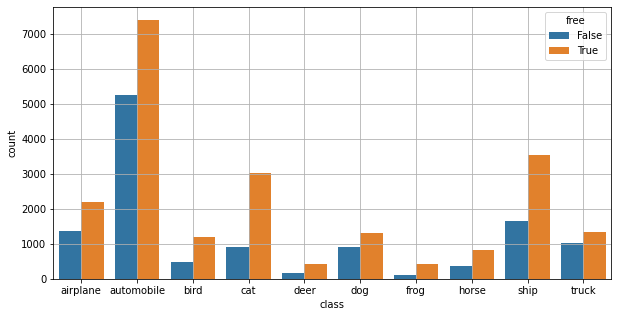

In [100]:
sns.countplot(data=frame, x='class', hue='free')
plt.grid()
plt.gcf().set_size_inches((10, 5))

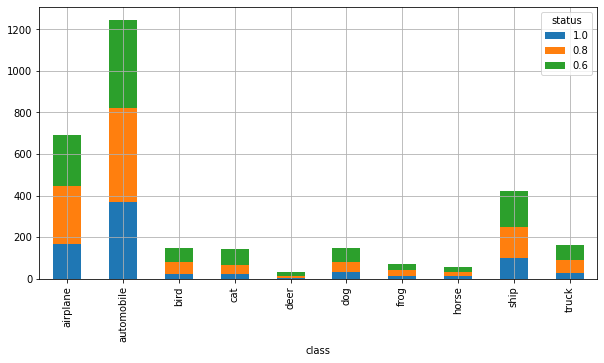

In [101]:
a = frame[frame['status'] >= 0.6]
a = a[['class', 'status','uid']].groupby(['class', 'status'], as_index=False).count()
a = a.reset_index(drop=True)
a = a.pivot(columns='status', index='class', values='uid')
a = a[list(reversed(a.columns))]
a.plot(kind='bar', stacked=True)
plt.gcf().set_size_inches((10, 5))
plt.grid()